
# Data mining the hansard

Estimating contribution by party

In [29]:
%matplotlib inline
import sys
#sys.path.append('/home/fin/Documents/datamining_hansard/dh/lib/python3.4/site-packages/')

import nltk
import nltk.tokenize

import itertools

import glob
import lxml
import lxml.html
import requests
import os
import csv
import wordcloud
import matplotlib.pyplot as plt
from scipy.misc import imread
import numpy as np
import wordcloud


## Data gathering and parsing
### Get data
- mine hansard from theyworkforyou scrape for June 2015 onwards using lxml

In [30]:
page = requests.get("http://www.theyworkforyou.com/pwdata/scrapedxml/debates/")
tree = lxml.html.fromstring(page.text)
debates = tree.xpath('//a/text()')

# Find the filenames of all the daily hansard xmls for this parliament
debates2015 = [x for x in debates if x.startswith('debates2015')]
new_parliament = [x for x in debates2015 if int(x.split('-')[1]) > 4]

def download_file(url, folder):
    """
    Download a given url into specified folder
    """
    local_filename = url.split('/')[-1]
    if not os.path.exists(os.path.join(folder, local_filename)):
        r = requests.get(url, stream=True)
        with open(os.path.join(folder, local_filename), 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    f.flush()
        return local_filename

In [31]:
# download xmls
for xml in new_parliament:
    download_file("http://www.theyworkforyou.com/pwdata/scrapedxml/debates/"+xml,
                 "data")

### Parse the xml of debates

Generate 3 datastructs from xml and mp_data.csv mentioned below: 

- ```named_text``` (a list of tuples of MPs names and their speeches over time i.e. will appear multiple times if they speak several times) 
- ```words_spoken_by_mp``` (a dict keyed with the MPs name and valued by a tuple representing their party and concatenated text)
- ```party_talk``` (a dict keyed by the party name and valued by concatenated text of all speeches for all MPs belonging to it)

Additionally create the ancillary dict ```parties``` which contains the list of "real parties" and their respective number of MPs and the ```party_dict``` containing all MPs respective parties

#### named_text

In [32]:
def get_speaker_and_text(xml):
    """
    For a given xml file return a list of tuples
    of speeches and their speakers
    """
    with open(xml, 'rb') as fh:
        parsed_xml = fh.read()
    
    data = []
    root = lxml.etree.fromstring(parsed_xml)
    speeches = root.xpath('speech') 
    for speech in speeches:
        #if speech.get('nospeaker') is not None:
        speech_list = [x.text for x in speech.getchildren() if x.text is not None]
        
        speech_list = " ".join(speech_list)
        
        speaker =  speech.get('speakername')
        data.append((speaker, speech_list))
    
    return data

In [37]:
named_text = []
for xml in glob.glob(os.path.join("data", "*.xml")):
    named_text = named_text + get_speaker_and_text(xml)

In [40]:
named_text[-1]

('Jess Phillips',
 'Thank you, Mr Deputy Speaker, for giving me the opportunity to make my maiden speech. This is the first time I have been called a maiden, and it seems a little unusual as my children watch me from the Strangers Gallery. I assure everybody here that it is good that they are behind the glass—I can see them talking up there! I am exceptionally proud to be one of the new women MPs elected to this Parliament, and to be one of the working parents elected—we have a lot to offer when deciding what is best for our country, which has not always happened. Like those of my predecessor, John Hemming, my roots in Birmingham, Yardley run deep. I know from reading his maiden speech that this was a source of great pride for him—and I feel the same. A Brummie accent is a rare thing in this Chamber, and I look forward to changing that. Like so many Brummies, my nan and grandad from both my mother’s and father’s sides moved from Birmingham’s Peaky Blinders-famed inner city industrial a

#### parties and party_dict
Using mp_data.csv manually downloaded from http://www.theyworkforyou.com/mps/?f=csv to acquire party affiliations for each mp and generate a dict for quick lookup of an MP's party using their name

In [6]:
#Encoding issue thus the weird kwarg
with open('data/mp_data.csv',  encoding = "ISO-8859-1") as fh:
    mp_data = [x for x in csv.reader(fh)]

party_dict = {}
for mp in mp_data[1:]:
    # forename and surname fields
    name = mp[1] + ' ' + mp[2]
    party = mp[3]
    party_dict.update({name: party})

#Manual clean up of this data
#Add the speakers
party_dict.update({'Mr Speaker': 'Speaker'})
party_dict.update({'Mr Deputy Speaker': 'Speaker'})
party_dict.update({'Mr Speaker-Elect': 'Speaker'})
party_dict.update({'The Chairman': 'Speaker'})
party_dict.update({'The Second Deputy Chairman': 'Speaker'})
party_dict.update({'Madam Deputy Speaker': 'Speaker'})


#add Stephen Philip Rotheram for some reason
party_dict.update({'Stephen Philip Rotheram': 'Labour'})

#add multiple speakers
party_dict.update({'My Lords and Members of the House of Commons':'Multiple'})
party_dict.update({'Members of the House of Commons':'Multiple'})
party_dict.update({'Hon. Members':'Multiple'})
party_dict.update({'Several hon. Members':'Multiple'})

#add none
party_dict.update({None: 'None'})

# parties and MP number
parties = {'UKIP': 1, 
           'Sinn Féin': 4,  
           'Conservative': 330,
           'Labour': 232,  
           'Liberal Democrat': 8,
           'Independent': 1, 
           'UUP': 2, 
           'DUP': 8, 
           'Scottish National Party': 56,
           'Green': 1,
           'Social Democratic and Labour Party': 3, 
           'Plaid Cymru': 3}

#### words_spoken_by_mp

For just the actual parties therefore

- Combining Labour + labour co-op
- Ignoring None, Multiple, and Speaker "parties"

Get a dict keyed with each MP name and valued with a tuple of their party and a concatenated string of everything they have said

In [74]:
words_spoken_by_mp = {}

for speaker, text in named_text:
        text = text.replace("“", "\"")
        party = party_dict[speaker]
        # remove cruft "parties"
        if party == 'None' or party == 'Multiple' or party == 'Speaker':
            continue
        # collapse labour co-op and labour down to one party
        if party == 'Labour/Co-operative':
            party = 'Labour'
        
        if speaker in words_spoken_by_mp.keys():
            words_spoken_by_mp[speaker] = (party, words_spoken_by_mp[speaker][1] + ' ' + text)
        else:
            words_spoken_by_mp.update({speaker: (party, text)})


## Tokenize per MP speech

Use NLTK to tokenize each MP's speeches into words.  Then stem  tally the per MP speech

In [87]:
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [83]:
def text_string_to_vocab(speech_string):
    """
    Get unique vocabularly for a given string of transcribed
    text.
    Specifically, tokenize this to remove all vocabularly (i.e. just find strings
    of alphanumerical characters) resulting in a list of tokenized words
    Then use the WordNet Lemmatizer for lemmatization
    Convert this lemmatized list into a set to remove redundancy
    and return the length of the non-redundant lemmatization
    """
    lemma = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatized_set = set([lemma.lemmatize(word) for word in tokenizer.tokenize(speech_string)])
    return len(lemmatized_set)

# get MP vocab size in the same format as words_spoken_by_mp but replacing text with len of lemmatized speech
vocab_by_MP = {}
for MP in words_spoken_by_mp.keys():
    vocab_by_MP.update({MP : (words_spoken_by_mp[MP][0], text_string_to_vocab(words_spoken_by_mp[MP][1]))})

#### Generate the SVG data struct for D3.js visualisation 


In [105]:
d3_js_data = []
for MP in vocab_by_MP.keys():
    d3_js_data.append('{{MP: "{0}", id:"{3}", x: .{1}, r: .45, colour: "{2}", vocabulary: "{1}", party: "{2}"}}'.format(MP, vocab_by_MP[MP][1], vocab_by_MP[MP][0], MP.replace('.','').replace(' ','_').replace("'", '')))
d3_data = ",".join(d3_js_data)

In [106]:
d3_data

'{MP: "Edward Leigh", id:"Edward_Leigh", x: .3569, r: .45, colour: "Conservative", vocabulary: "3569", party: "Conservative"},{MP: "Michelle Donelan", id:"Michelle_Donelan", x: .1182, r: .45, colour: "Conservative", vocabulary: "1182", party: "Conservative"},{MP: "Jake Berry", id:"Jake_Berry", x: .1477, r: .45, colour: "Conservative", vocabulary: "1477", party: "Conservative"},{MP: "Holly Lynch", id:"Holly_Lynch", x: .928, r: .45, colour: "Labour", vocabulary: "928", party: "Labour"},{MP: "Gloria De Piero", id:"Gloria_De_Piero", x: .823, r: .45, colour: "Labour", vocabulary: "823", party: "Labour"},{MP: "Roberta Blackman-Woods", id:"Roberta_Blackman-Woods", x: .1026, r: .45, colour: "Labour", vocabulary: "1026", party: "Labour"},{MP: "Henry Smith", id:"Henry_Smith", x: .1162, r: .45, colour: "Conservative", vocabulary: "1162", party: "Conservative"},{MP: "Neil Gray", id:"Neil_Gray", x: .1810, r: .45, colour: "Scottish National Party", vocabulary: "1810", party: "Scottish National Party

#### party_talk
Also generate a dict for each party valued by the concatenated string of everything their MPs have said

In [9]:
# Initialise party talk dict with each party name
party_talk = {}
for party in parties.keys():
    party_talk.update({party:''})
 
for speaker, party_and_text in words_spoken_by_mp.items():
    # will throw error if party doesn't exist in parties list
    party, text = party_and_text
 

    if len(party_talk[party]) == 0:
        party_talk[party] = text
    else:
        party_talk[party] = party_talk[party] + ' ' + text

In [12]:
con_sentences = nltk.tokenize.sent_tokenize(party_talk['Conservative'])
con_sentences = ["{0} {1} {2}".format("START_TOKEN", w, "END_TOKEN") for w in con_sentences]
con_sentences = [nltk.word_tokenize(sentence) for sentence in con_sentences]


['START_TOKEN',
 'Where',
 'possible',
 ',',
 'we',
 'are',
 'looking',
 'at',
 'alternative',
 'solutions',
 'and',
 ',',
 'of',
 'course',
 ',',
 'we',
 'are',
 'bringing',
 'forward',
 'carbon',
 'capture',
 'and',
 'storage',
 'as',
 'a',
 'long-term',
 'solution',
 '.',
 'END_TOKEN']

In [16]:
word_freqs = nltk.FreqDist(con_sentences)
vocab = word_freqs.most_common(9999)

idx_2_word = [x[0] for x in vocab]
idx_2_word.append("TOO_INFREQUENT_WORD")
word_2_idx = dict([(w,i) for i,w in enumerate(idx_2_word)])

for i, sentence in enumerate(con_sentences):
    con_sentences[i] = [word if word in word_2_idx else "TOO_INFREQUENT_WORD"  for word in sentence]

    
X_train = np.asarray([[word_2_idx[w] for w in sent[:-1]] for sent in con_sentences])
Y_train = np.asarray([[word_2_idx[w] for w in sent[1:]] for sent in con_sentences])

TypeError: __init__() takes from 1 to 2 positional arguments but 147486 were given


## Analysis

Using the raw data discover the following:

- Average number of words spoken by party
- word cloud of spoken words by party
- plot of total words spoken for each MP highlighted by party

Then apply NLTK methods and look at vocabulary:

- Average vocab of each party
- replot word clouds used token analysis
- plot of total vocab for each MP highlighted by party

Other ideas 

- NLTK dispersion plot of words like "austerity"
- frequency distribution by party top words by token and their context
- word redundancy by party - i.e. unique words which parties repeat the same shit over and over (lexical_diversity)
- longest word by party 
- which MP uses the longest words on average - distribution
- collocations
http://www.nltk.org/book/ch01.html#counting-vocabulary

### Party-wise summaries

- Total speech per MP per Party

In [13]:
total_speech = []
for speaker, party_text in words_spoken_by_mp.items():
    total_speech.append((speaker, party_text[0], len(party_text[1])))

In [14]:
average_totals = []
for party, mp_number in parties.items():
    average_totals.append((party, len(party_talk[party])/mp_number))
average_totals = sorted(average_totals, key=lambda x: x[1], reverse=True)

for party, average in average_totals:
    print("{0:<40s}: {1:>10,.1f}".format(party, average))

Green                                   :  108,574.0
Social Democratic and Labour Party      :   91,118.3
DUP                                     :   64,063.9
Scottish National Party                 :   57,385.4
Liberal Democrat                        :   55,469.6
Conservative                            :   52,366.0
UUP                                     :   43,351.5
Plaid Cymru                             :   42,344.0
Labour                                  :   40,961.8
Independent                             :   26,885.0
UKIP                                    :   25,777.0
Sinn Féin                               :        0.0


In [19]:
y_pos = np.arange(len(average_totals))
plt.figure(figsize=(10,10))
plot_mp_numbers = [parties[x[1]] for x in average_totals]
plt.bar(y_pos, [x[1] for x in average_totals], align='center', alpha=0.4)
plt.xticks(y_pos, [x[0] for x in average_totals], rotation=90)
plt.ylabel('Average words spoken per MP')
plt.xlabel('Party')
plt.show()

KeyError: 108574.0

- Wordclouds

In [16]:
def make_wordcloud(text, image_filename=None):
    """
    Generate a wordcloud
    """
    # remove minor words
    wordcloud.STOPWORDS.add("hon")
    wordcloud.STOPWORDS.add("Government")
    wordcloud.STOPWORDS.add("government")
    wordcloud.STOPWORDS.add("Minister")
    wordcloud.STOPWORDS.add("minister")
    wordcloud.STOPWORDS.add("S")
    wordcloud.STOPWORDS.add("s")
    wordcloud.STOPWORDS.add("Member")
    wordcloud.STOPWORDS.add("Friend")


    if image_filename:
        mask = imread(image_filename)
        wc = wordcloud.WordCloud(background_color="white", max_words=2000, mask=mask,
                   stopwords=wordcloud.STOPWORDS)
    else:
        wc = wordcloud.WordCloud(background_color="white", max_words=2000, stopwords=wordcloud.STOPWORDS)

    
    wc.generate(text)
    
    return wc

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


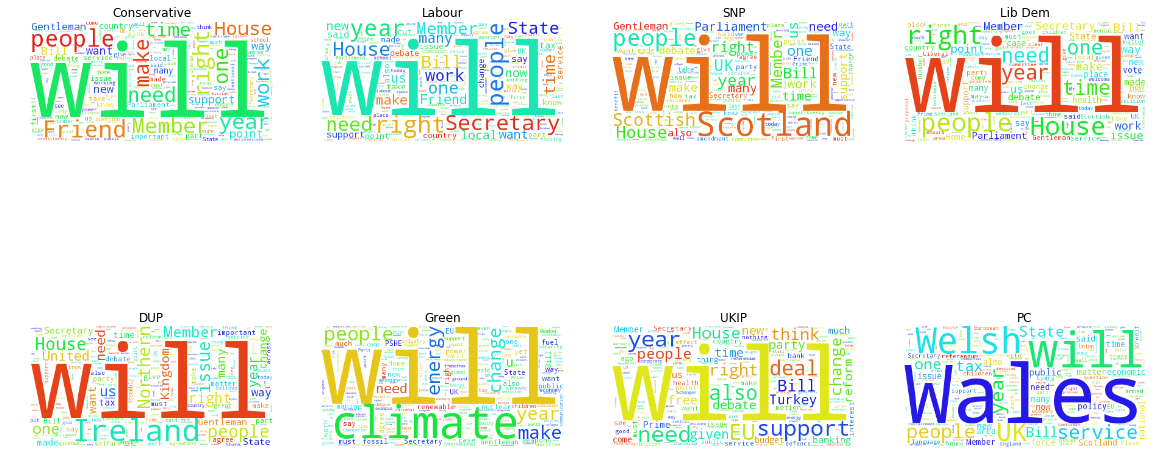

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(241)
plt.imshow(make_wordcloud(party_talk['Conservative']))
plt.axis("off")
plt.title('Conservative')

plt.subplot(242)
plt.imshow(make_wordcloud(party_talk['Labour']))
plt.axis("off")
plt.title('Labour')

plt.subplot(243)
plt.imshow(make_wordcloud(party_talk['Scottish National Party']))
plt.axis("off")
plt.title('SNP')

plt.subplot(244)
plt.imshow(make_wordcloud(party_talk['Liberal Democrat']))
plt.axis("off")
plt.title('Lib Dem')

plt.subplot(245)
plt.imshow(make_wordcloud(party_talk['DUP']))
plt.axis("off")
plt.title('DUP')

plt.subplot(246)
plt.imshow(make_wordcloud(party_talk['Green']))
plt.axis("off")
plt.title('Green')

plt.subplot(247)
plt.imshow(make_wordcloud(party_talk['UKIP']))
plt.axis("off")
plt.title('UKIP')

plt.subplot(248)
plt.imshow(make_wordcloud(party_talk['Plaid Cymru']))
plt.axis("off")
plt.title('PC')


# Total spoken plot

Generate data for d3 plot of total spoken words per MP (based on http://experiments.undercurrent.com/)

```Format data = {MP: NAME, 
                  x: 0.WORDS, 
                  r: .3, 
                  color: PARTY, 
                  words: "WORDS", 
                  id:NAME,
                  party: PARTY
                  cx: 
                  cy:```

5